# Variant distributions

In [1]:
import hail as hl
hl.init(spark_conf={'spark.driver.memory': '100g'}, tmp_dir='/home/olavur/tmp')

2021-11-08 11:26:56 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2021-11-08 11:26:57 WARN  Hail:37 - This Hail JAR was compiled for Spark 2.4.5, running with Spark 2.4.1.
  Compatibility is not guaranteed.
2021-11-08 11:26:57 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Running on Apache Spark version 2.4.1
SparkUI available at http://hms-beagle-6676655f87-9xllv:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.61-3c86d3ba497a
LOGGING: writing to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/fargen-1-exome/notebooks/main/hail-20211108-1126-0.2.61-3c86d3ba497a.log


In [2]:
from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models.scales import LogScale
output_notebook()

Loading BokehJS ...

## Read data

In [3]:
BASE_DIR = '/home/olavur/experiments/2020-11-13_fargen1_exome_analysis'
RESOURCES_DIR = '/data/other/resources'

In [4]:
import pandas as pd
import numpy as np

Merged FarGen and gnomAD sites. This dataset only contains the population frequency of variants and SnpEff annotations. See the notebooks in the `gnomad_exome_sites` folder.

In [8]:
ht = hl.read_table(BASE_DIR + '/data/resources/gnomad_exome_sites/fargen_gnomad_union_annotated.ht')

In [6]:
n_variants = ht.count()
print('Number of variants: ' + str(n_variants))

Number of variants: 15692611


In [7]:
ht.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'rsid': str 
    'qual': float64 
    'filters': set<str> 
    'info': struct {
        AF_gnomad_all: float64, 
        AF_afr: float64, 
        AF_sas: float64, 
        AF_amr: float64, 
        AF_eas: float64, 
        AF_nfe: float64, 
        AF_fin: float64, 
        AF_nfe_nwe: float64, 
        AF_nfe_seu: float64, 
        AC_gnomad_all: int32, 
        AC_afr: int32, 
        AC_sas: int32, 
        AC_amr: int32, 
        AC_eas: int32, 
        AC_nfe: int32, 
        AC_fin: int32, 
        AC_nfe_nwe: int32, 
        AC_nfe_seu: int32, 
        AF_fae: float64, 
        AC_fae: int32, 
        ANN: array<str>, 
        LOF: array<str>, 
        NMD: array<str>
    } 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


## Impute missing allele frequencies

The private alleles have missing frequency in the other populations. So we replace the missing values with zeros.

In [9]:
ht = ht.annotate(info = 
                 ht.info.annotate(
                     AF_fae = hl.if_else(hl.is_missing(ht.info.AF_fae), 0, ht.info.AF_fae),
                     AF_gnomad_all = hl.if_else(hl.is_missing(ht.info.AF_gnomad_all), 0, ht.info.AF_gnomad_all),
                     AF_nfe_nwe = hl.if_else(hl.is_missing(ht.info.AF_nfe_nwe), 0, ht.info.AF_nfe_nwe),
                     AF_fin = hl.if_else(hl.is_missing(ht.info.AF_fin), 0, ht.info.AF_fin),
                     AC_fae = hl.if_else(hl.is_missing(ht.info.AC_fae), 0, ht.info.AC_fae),
                     AC_gnomad_all = hl.if_else(hl.is_missing(ht.info.AC_gnomad_all), 0, ht.info.AC_gnomad_all),
                     AC_nfe_nwe = hl.if_else(hl.is_missing(ht.info.AC_nfe_nwe), 0, ht.info.AC_nfe_nwe),
                     AC_fin = hl.if_else(hl.is_missing(ht.info.AC_fin), 0, ht.info.AC_fin)
                 )
                )

## Count variants

Annotate variants with variant effect, impact and gene. These annotations are obtained from SnpEff.

If multiple transcripts overlap a site, the first in the list is arbitrarily chosen.

**NOTE:** is it possible to use [split_multi()](https://hail.is/docs/0.2/methods/genetics.html#hail.methods.split_multi) to count overlapping transcripts separately?

In [10]:
# Get variant impact, effect and gene name.
# Split overlapping transcripts into a list.
ht = ht.annotate(effect=ht.info.ANN.map(lambda x: x.split('\|')[1]),
                      impact=ht.info.ANN.map(lambda x: x.split('\|')[2]))
# Use only the first transcript.
ht = ht.annotate(impact1=ht.impact[0].split('&'), effect1=ht.effect[0].split('&'))

In [192]:
def variant_counts(ht, AF_exprs):
    # Count number of variants, SNPs and indels. Only first allele in alternate allele list is considered.
    variant_counts_struct = ht.aggregate(hl.struct(
        n_variants = hl.agg.count(),
        snps = hl.agg.count_where(hl.is_snp(ht.alleles[0], ht.alleles[1])) / hl.agg.count(),
        indels = hl.agg.count_where(hl.is_indel(ht.alleles[0], ht.alleles[1])) / hl.agg.count(),
            LOW = hl.agg.count_where(ht.impact1.contains('LOW')) / hl.agg.count(),
            MODIFIER = hl.agg.count_where(ht.impact1.contains('MODIFIER')) / hl.agg.count(),
            MODERATE = hl.agg.count_where(ht.impact1.contains('MODERATE')) / hl.agg.count(),
            HIGH = hl.agg.count_where(ht.impact1.contains('HIGH')) / hl.agg.count(),
            synonymous_variant = hl.agg.count_where(ht.effect1.contains('synonymous_variant')) / hl.agg.count(),
            missense_variant = hl.agg.count_where(ht.effect1.contains('missense_variant')) / hl.agg.count(),
            intron_variant = hl.agg.count_where(ht.effect1.contains('intron_variant')) / hl.agg.count(),
            ultra_rare_variant = hl.agg.count_where(AF_exprs < 0.01) / hl.agg.count(),
            rare_variant = hl.agg.count_where(AF_exprs < 0.05) / hl.agg.count(),
            common_variant = hl.agg.count_where(AF_exprs > 0.05) / hl.agg.count()
    ))
    
    variant_counts_pd = pd.DataFrame(variant_counts_struct.values(), index=variant_counts_struct.keys(), columns=[''])
    return variant_counts_pd

def impact_counts(ht):
    # Count variant impact types.
    impact_counts_struct = ht.aggregate(
        hl.struct(
            LOW = hl.agg.count_where(ht.impact1.contains('LOW')) / hl.agg.count(),
            MODIFIER = hl.agg.count_where(ht.impact1.contains('MODIFIER')) / hl.agg.count(),
            MODERATE = hl.agg.count_where(ht.impact1.contains('MODERATE')) / hl.agg.count(),
            HIGH = hl.agg.count_where(ht.impact1.contains('HIGH')) / hl.agg.count()))
    
    impact_counts_pd = pd.DataFrame(impact_counts_struct.values(), index=impact_counts_struct.keys(), columns=[''])
    return impact_counts_pd

def effect_counts(ht):
    # Count variant effect types.
    # There are many more effect types, these are some of the more interesting ones.
    effect_counts_struct = ht.aggregate(
        hl.struct(
            synonymous_variant = hl.agg.count_where(ht.effect1.contains('synonymous_variant')) / hl.agg.count(),
            missense_variant = hl.agg.count_where(ht.effect1.contains('missense_variant')) / hl.agg.count(),
            intron_variant = hl.agg.count_where(ht.effect1.contains('intron_variant')) / hl.agg.count()))
    
    effect_counts_pd = pd.DataFrame(effect_counts_struct.values(), index=effect_counts_struct.keys(), columns=[''])
    return effect_counts_pd

def rarity_counts(ht, AF_exprs):
    counts_struct = ht.aggregate(
        hl.struct(
            ultra_rare_variant = hl.agg.count_where(AF_exprs < 0.01) / hl.agg.count(),
            rare_variant = hl.agg.count_where(AF_exprs < 0.05) / hl.agg.count(),
            common_variant = hl.agg.count_where(AF_exprs > 0.05) / hl.agg.count()
        )
    )
    
    counts_struct = pd.DataFrame(counts_struct.values(), index=counts_struct.keys(), columns=[''])
    return counts_struct

In [195]:
# Variants with non-zero alternate allele frequency in FarGen.
fae_ht = ht.filter((ht.info.AF_fae > 0) & (ht.info.AC_fae > 1))
fae_variant_counts_pd = variant_counts(fae_ht, fae_ht.info.AF_fae)

[Stage 14:=======================================================>(78 + 1) / 79]

In [196]:
# Variants with non-zero alternate allele frequency in gnomAD.
gnomad_all_ht = ht.filter((ht.info.AF_gnomad_all > 0) & (ht.info.AC_gnomad_all > 1))
gnomad_all_variant_counts_pd = variant_counts(gnomad_all_ht, gnomad_all_ht.info.AF_gnomad_all)

[Stage 15:=======================================================>(78 + 1) / 79]

In [197]:
# Variants with non-zero alternate allele frequency in gnomAD.
gnomad_nfe_nwe_ht = ht.filter((ht.info.AF_nfe_nwe > 0) & (ht.info.AC_nfe_nwe > 1))
gnomad_nfe_nwe_variant_counts_pd = variant_counts(gnomad_nfe_nwe_ht, gnomad_nfe_nwe_ht.info.AF_nfe_nwe)

[Stage 16:=======================================================>(78 + 1) / 79]

In [204]:
# Variants with non-zero alternate allele frequency in gnomAD.
gnomad_fin_ht = ht.filter((ht.info.AF_fin > 0) & (ht.info.AC_fin > 1))
gnomad_fin_variant_counts_pd = variant_counts(gnomad_fin_ht, gnomad_fin_ht.info.AF_fin)

[Stage 17:=======================================================>(78 + 1) / 79]

In [205]:
# Concatenate columns, FarGen, gnomAD and enriched.
#variant_counts_pd = pd.concat([fae_variant_counts_pd, gnomad_all_variant_counts_pd, gnomad_nfe_nwe_variant_counts_pd, gnomad_fin_variant_counts_pd], axis=1)
#effect_counts_pd = pd.concat([fae_effect_counts_pd, gnomad_all_effect_counts_pd, gnomad_nfe_nwe_effect_counts_pd, gnomad_fin_effect_counts_pd], axis=1)
#impact_counts_pd = pd.concat([fae_impact_counts_pd, gnomad_all_impact_counts_pd, gnomad_nfe_nwe_impact_counts_pd, gnomad_fin_impact_counts_pd], axis=1)

counts_pd = pd.concat([fae_variant_counts_pd, gnomad_all_variant_counts_pd, gnomad_nfe_nwe_variant_counts_pd, gnomad_fin_variant_counts_pd], axis=1)

# Concatenate rows, variants, effects and impact.
#counts_pd = pd.concat([variant_counts_pd, effect_counts_pd, impact_counts_pd])

# Set column names.
counts_pd.columns = ['FarGen', 'gnomAD', 'NWE', 'FIN']

In [206]:
pd.set_option('display.float_format', lambda x: '%g' % x)

Add sample sizes to the dataframe. Sample sizes taken from this blog post: https://gnomad.broadinstitute.org/news/2018-10-gnomad-v2-1/

In [207]:
temp_pd = pd.DataFrame([[465, 141456, 25410,  12562]], columns=counts_pd.columns, index=['sample_size'])
counts_pd = counts_pd.append(temp_pd)

In [208]:
counts_pd

,FarGen,gnomAD,NWE,FIN
n_variants,59345,7.11172e+06,1.65400e+06,534266
snps,0.902839,0.942463,0.926923,0.893652
indels,0.0971607,0.0575371,0.073076,0.106346
LOW,0.295257,0.231335,0.237523,0.236809
MODIFIER,0.454175,0.372967,0.389407,0.417627
MODERATE,0.232218,0.357389,0.337796,0.310261
HIGH,0.0183503,0.0383087,0.0352738,0.0353026
synonymous_variant,0.239751,0.185857,0.189725,0.182231
missense_variant,0.222934,0.347815,0.327556,0.299349
intron_variant,0.366484,0.287795,0.298962,0.331006


## Least-Squares regression test

Make a least-squares regression between sample size and the other variables.

A linear regression is fitted between `n_variants` and `sample_size`. For all other variables, an exponential regression is fitted, as $y = a \log{x} + b + \epsilon$.

In [313]:
linreg_results = []
for TYPE in list(dict.fromkeys(counts_pd.index)):
    if TYPE == 'sample_size':
        continue
    
    y = counts_pd.T[TYPE]
    
    if TYPE != 'n_variants':
        x = np.log(counts_pd.T['sample_size'])
    else:
        x = counts_pd.T['sample_size']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    if slope > 0:
        slope_sign = '+'
    elif slope < 0:
        slope_sign = '-'
    else:
        slope_sign = '0'
    
    if p_value < 0.05:
        significance = '*'
    else:
        significance = ''
    
    linreg_results.append({'type': TYPE, 'slope': slope, 'slope_sign': slope_sign, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value, 'significance': significance, 'std_err': std_err})
    
    #print('Type: {t}\nSlope: {s}\nIntercept: {i}\nR-value: {r}\nP-value: {p}\nStd. error: {std}\n'.format(t=TYPE, s=slope, i=intercept, r=r_value, p=p_value, std=std_err))

linreg_results_pd = pd.DataFrame(linreg_results)
linreg_results_pd.index = linreg_results_pd['type']

In [314]:
linreg_results_pd

,type,slope,slope_sign,intercept,r_value,p_value,significance,std_err
type,,,,,,,,
n_variants,n_variants,49.8183,+,99346.1,0.998026,0.00197389,*,2.21663
snps,snps,0.00669255,+,0.853588,0.71911,0.28089,,0.004573
indels,indels,-0.00669263,-,0.146412,-0.719132,0.280868,,0.00457277
LOW,LOW,-0.0117974,-,0.361076,-0.937593,0.0624069,,0.00309388
MODIFIER,MODIFIER,-0.0145221,-,0.544991,-0.977963,0.0220369,*,0.00219219
MODERATE,MODERATE,0.022687,+,0.0962539,0.988635,0.0113647,*,0.0024394
HIGH,HIGH,0.00363247,+,-0.00232102,0.957909,0.042091,*,0.000769757
synonymous_variant,synonymous_variant,-0.0100255,-,0.293589,-0.886938,0.113062,,0.00369179
missense_variant,missense_variant,0.0226001,+,0.0870679,0.989396,0.0106042,*,0.00234598


### Plot counts

In [211]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [315]:
count_plot_pd = counts_pd.drop(['n_variants', 'sample_size']).T
count_plot_pd = pd.melt(count_plot_pd, ignore_index=False, var_name='Type', value_name='Fraction')
count_plot_pd['Strata'] = count_plot_pd.index

linreg_results_temp_pd = linreg_results_pd.drop('n_variants')

/opt/conda/envs/fargen-1-exome/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


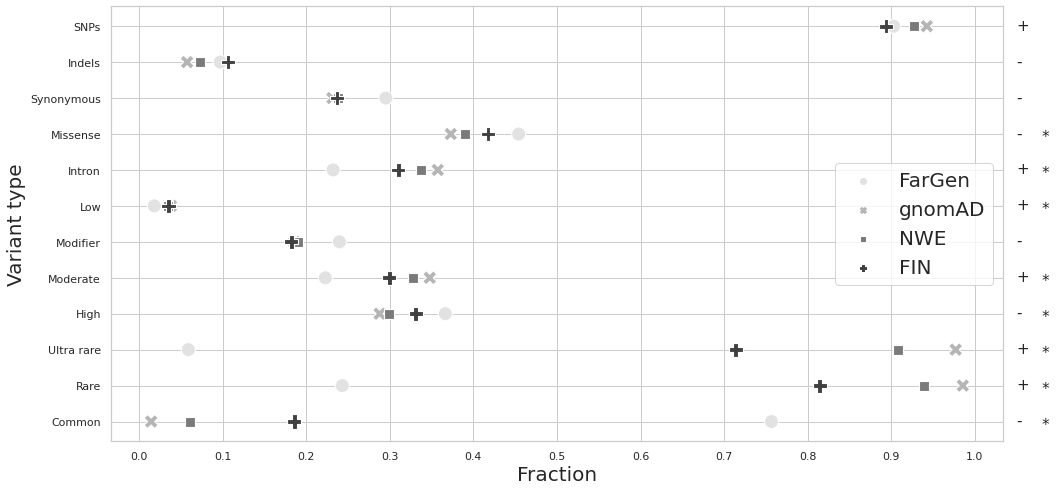

In [321]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(figsize=(16, 8))

g = sns.scatterplot(
    data=count_plot_pd, x='Fraction', y='Type', hue='Strata', style='Strata',
    ax=ax, s=200, palette='Greys'
)

for i, slope_sign in enumerate(linreg_results_temp_pd['slope_sign']):
    g.text(1.05, i + 0.1, slope_sign, size=15)

for i, significance in enumerate(linreg_results_temp_pd['significance']):
    g.text(1.08, i + 0.2, significance, size=15)

ax.set_xlabel('Fraction', fontsize=20)
ax.set_ylabel('Variant type', fontsize=20)

_ = ax.legend(prop={'size': 20})

ax.set_xticks(np.linspace(0, 1, 11))

_ = (g.set_yticklabels(['SNPs', 'Indels', 'Synonymous', 'Missense', 'Intron', 'Low', 'Modifier', 'Moderate', 'High', 'Ultra rare', 'Rare', 'Common']))

In [229]:
fig = g.get_figure()
fig.savefig(BASE_DIR + '/data/figures/variant_counts_by_pop_and_type.png', format='png', dpi=400)

The same figure in color.

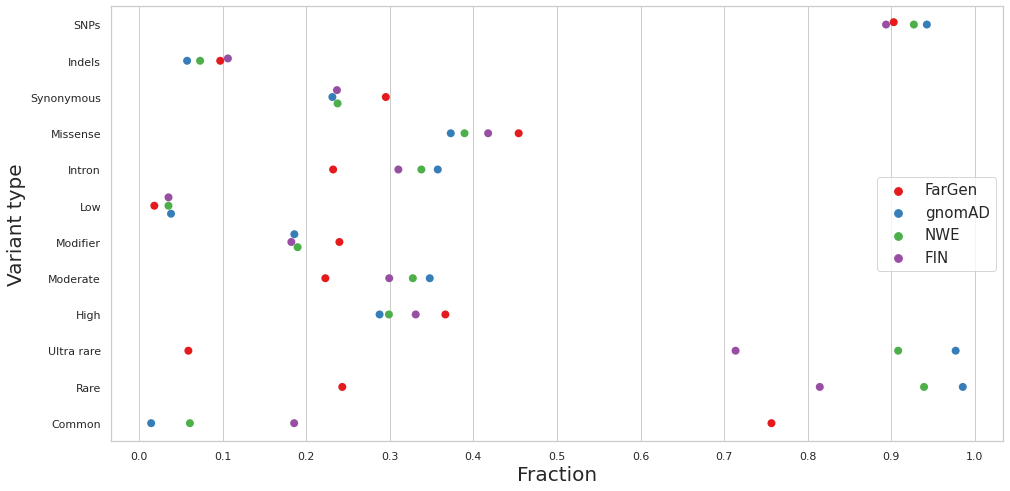

In [227]:
sns.set_theme(style='whitegrid')

# NOTE: context doesn't work.
#sns.plotting_context('paper', font_scale=2)

fig, ax = plt.subplots(figsize=(16, 8))

Markers = ['o', '+', '^', 'x']

g = sns.swarmplot(
    data=count_plot_pd, x='Fraction', y='Type', hue='Strata',
    ax=ax, size=8, palette='Set1'
)

ax.set_xlabel('Fraction', fontsize=20)
ax.set_ylabel('Variant type', fontsize=20)

_ = ax.legend(prop={'size': 15})

ax.set_xticks(np.linspace(0, 1, 11))

_ = (g.set_yticklabels(['SNPs', 'Indels', 'Synonymous', 'Missense', 'Intron', 'Low', 'Modifier', 'Moderate', 'High', 'Ultra rare', 'Rare', 'Common']))

In [29]:
fig = g.get_figure()
fig.savefig(BASE_DIR + '/data/figures/color_variant_counts_by_pop_and_type.png', format='png', dpi=400)

Sample sizes taken from this blog post: https://gnomad.broadinstitute.org/news/2018-10-gnomad-v2-1/

In [220]:
sample_sizes_pd = counts_pd.loc[['n_variants', 'sample_size']]
sample_sizes_pd = sample_sizes_pd.T

#sample_sizes_pd = pd.melt(sample_sizes_pd, ignore_index=False, var_name='Strata', value_name='Size')
sample_sizes_pd['Strata'] = sample_sizes_pd.index

Fit a line to the log10 transformed data.

In [222]:
sample_sizes_pd['n_variants_log10'] = np.log10(sample_sizes_pd.n_variants)
sample_sizes_pd['sample_size_log10'] = np.log10(sample_sizes_pd.sample_size)

# As we are using log10 scale, we use a vector of zeros as the first column of X.
X = np.vstack([np.ones((4,)), sample_sizes_pd.sample_size_log10]).T
y = np.reshape(np.array(sample_sizes_pd.n_variants_log10), (4,1))

X_inv = np.linalg.pinv(X)

A = X_inv.dot(y)

y = A[0, 0] + A[1, 0] * sample_sizes_pd.sample_size_log10
sample_sizes_pd['y_line'] = y

In [223]:
import matplotlib.ticker as ticker

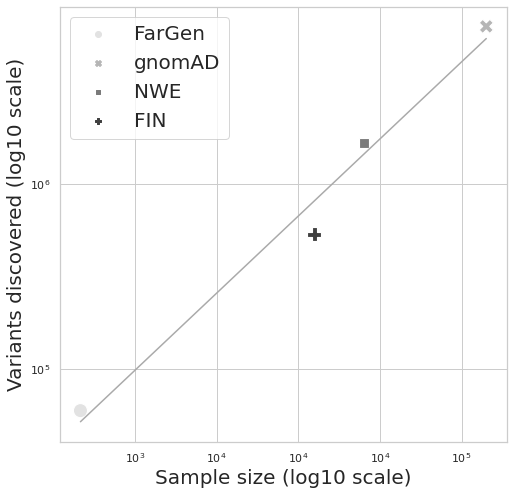

In [224]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.set_theme(style='whitegrid', font_scale=1.2)
#sns.set(font_scale=20)

g = sns.scatterplot(
    data=sample_sizes_pd, x='sample_size_log10', y='n_variants_log10', hue='Strata', style='Strata',
    ax=ax, s=200, palette='Greys'
)

g2 = sns.lineplot(data=sample_sizes_pd, x='sample_size_log10', y='y_line', color='#aaaaaa', ax=ax)

ax.yaxis.set_ticks([5,6])
_ = ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$10^{%.0f}$'))
_ = ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$10^{%.0f}$'))
_ = ax.legend(prop={'size': 20})
_ = ax.set_xlabel('Sample size (log10 scale)', fontsize=20)
_ = ax.set_ylabel('Variants discovered (log10 scale)', fontsize=20)

In [67]:
fig = g.get_figure()
fig.savefig(BASE_DIR + '/data/figures/pop_variants_and_size.png', format='png', dpi=400)

### Linear regression between variables

In [294]:
linreg_pd = counts_pd.T

linreg_pd['Strata'] = linreg_pd.index

linreg_pd = pd.melt(linreg_pd, id_vars=['Strata', 'sample_size'], var_name='Type', value_name='Value', ignore_index=False)

/opt/conda/envs/fargen-1-exome/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


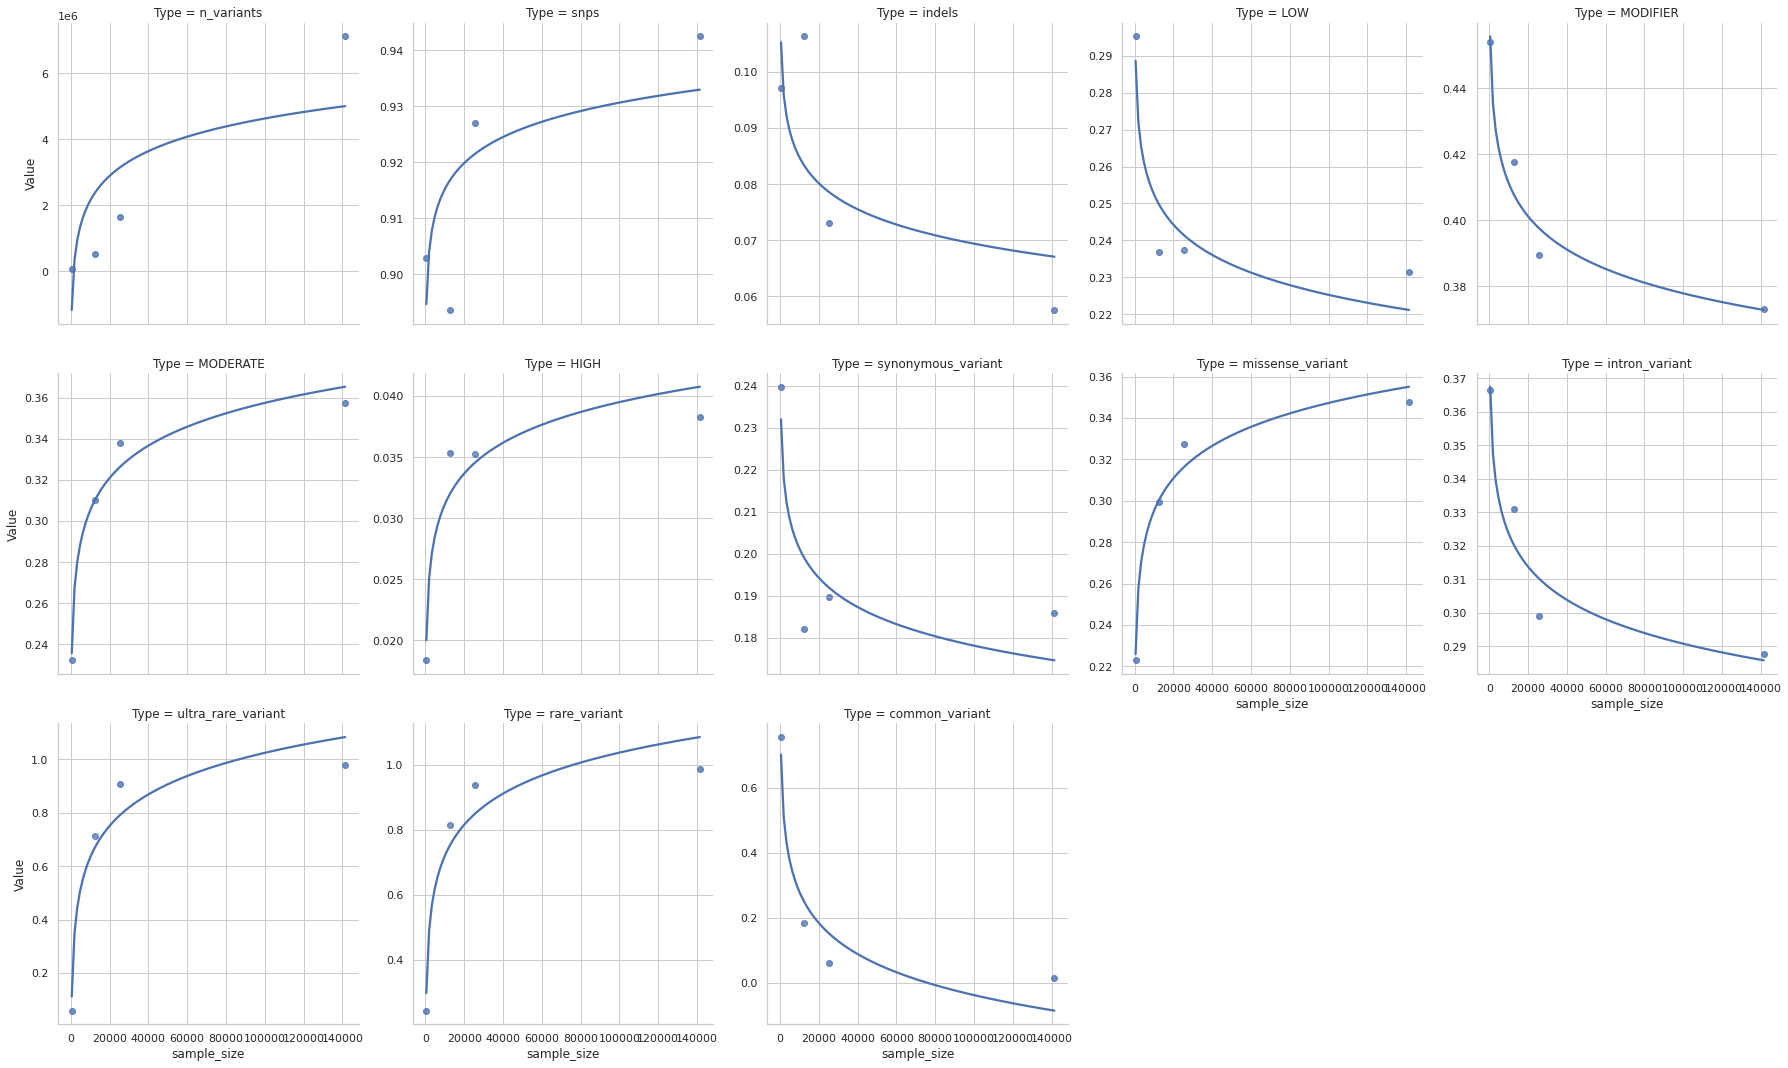

In [322]:
pp = sns.lmplot(data=linreg_pd, x='sample_size', y='Value', col='Type', sharey=False, ci=False, col_wrap=5, logx=True)

### Intersection and union

In [24]:
venn_count = ht.aggregate(hl.struct(
    fae = hl.agg.count_where((ht.info.AF_fae > 0) & (ht.info.AF_gnomad_all == 0)),
    gnomad = hl.agg.count_where((ht.info.AF_gnomad_all > 0) & (ht.info.AF_fae == 0)),
    intersection = hl.agg.count_where((ht.info.AF_gnomad_all > 0) & (ht.info.AF_fae > 0))
))

[Stage 15:=============================================>         (66 + 13) / 79]

In [25]:
venn_count = venn_count.annotate(union = venn_count.fae + venn_count.gnomad + venn_count.intersection)

In [26]:
pd.DataFrame(venn_count.values(), index=venn_count.keys(), columns=[''])

,
fae,55
gnomad,14886696
intersection,59297
union,14946048


## Folded Site Frequency Spectrum (FSFS)

Let $f_i$ be the *site frequency* of bin $i$, where bin $i$ corresponds to some range of *allele frequencies*. We are going to compute the folded frequencies $f^*_i = f_i + f_{n-i}$.

Example: if we have 10 bins, then $f^*_1 = f_1 + f_{10}$.

Below a function that computes the FSFS is defined.

In [8]:
def fsfs(n_bins, ht, af_exprs):
    # Make sure the number of bins is an even number.
    assert n_bins % 2 == 0, 'Number of bins must be an even number.'
    hist_struct = ht.aggregate(hl.agg.hist(af_exprs, 0, 1, n_bins))

    # Allele frequency.
    allele_freq = hist_struct.bin_edges

    # The site count is the number of times frequencies in each bin is observed.
    site_counts = np.array(hist_struct.bin_freq)

    # Calculate site frequencies.
    n_sites = sum(site_counts)
    site_freq = site_counts / n_sites

    # Calculate folded site-frequencies.
    half = int(n_bins/2)
    folded_site_freq = site_freq[:half] + site_freq[:half-1:-1]

    # Make a Hail table with the allele counts and site frequencies.
    fsfs_table = []
    for ac, fc in zip(allele_freq, folded_site_freq):
        row = {'af': ac, 'ff': fc}
        fsfs_table.append(row)

    # Make a table where each row is a bin, and each row contains the allele frequency and the folded site-frequency.
    ht_fsfs = hl.Table.parallelize(hl.literal(fsfs_table, 'array<struct{af:float32,ff:float32}>'))

    return ht_fsfs

In [28]:
fae_ht = ht.filter(ht.info.AC_fae != 0)
fae_fsfs_ht = fsfs(50, fae_ht, fae_ht.info.AF_fae)

[Stage 16:===================================================>    (72 + 7) / 79]

In [29]:
p = hl.plot.scatter(fae_fsfs_ht.af, fae_fsfs_ht.ff,
                    xlabel='Allele counts', ylabel='Frequency in population')
p.plot_width = 800
p.plot_height = 400
show(p)

## FSFS strafified by population

In [9]:
n_bins = 50

fae_ht = ht.filter(ht.info.AC_fae > 1)
fae_fsfs_ht = fsfs(n_bins, fae_ht, fae_ht.info.AF_fae)
fae_fsfs_ht = fae_fsfs_ht.annotate(strata='FarGen')

gnomad_ht = ht.filter(ht.info.AC_gnomad_all > 1)
gnomad_fsfs_ht = fsfs(n_bins, gnomad_ht, gnomad_ht.info.AF_gnomad_all)
gnomad_fsfs_ht = gnomad_fsfs_ht.annotate(strata='gnomAD')

gnomad_nfe_nwe_ht = ht.filter(ht.info.AC_nfe_nwe > 1)
gnomad_nfe_nwe_fsfs_ht = fsfs(n_bins, gnomad_nfe_nwe_ht, gnomad_nfe_nwe_ht.info.AF_nfe_nwe)
gnomad_nfe_nwe_fsfs_ht = gnomad_nfe_nwe_fsfs_ht.annotate(strata='NWE')

gnomad_fin_ht = ht.filter(ht.info.AC_fin > 1)
gnomad_fin_fsfs_ht = fsfs(n_bins, gnomad_fin_ht, gnomad_fin_ht.info.AF_fin)
gnomad_fin_fsfs_ht = gnomad_fin_fsfs_ht.annotate(strata='FIN')

fsfs_ht = fae_fsfs_ht.union(gnomad_fsfs_ht)
fsfs_ht = fsfs_ht.union(gnomad_nfe_nwe_fsfs_ht)
fsfs_ht = fsfs_ht.union(gnomad_fin_fsfs_ht)

[Stage 3:==============================================>         (66 + 13) / 79]

In [318]:
fsfs_ht.group_by(fsfs_ht.strata).aggregate(ff_sum=hl.agg.sum(fsfs_ht.ff)).collect()

2021-10-28 13:40:07 Hail: INFO: Coerced sorted dataset
2021-10-28 13:40:07 Hail: INFO: Coerced dataset with out-of-order partitions.


[Struct(strata='FIN', ff_sum=1.0000000018626451),
 Struct(strata='FarGen', ff_sum=0.9999999925494194),
 Struct(strata='NWE', ff_sum=0.9999999860301614),
 Struct(strata='gnomAD', ff_sum=1.0000000166764949)]

In [10]:
p = hl.plot.scatter(fsfs_ht.af, fsfs_ht.ff, label=fsfs_ht.strata,
                    xlabel='Allele counts', ylabel='Frequency in population',
                    collect_all=True)
p.plot_width = 1200
p.plot_height = 600
show(p)

In [15]:
p.y_scale = LogScale()
p.axis[1].axis_label = 'Frequency in population (log10 scale)'
show(p)

## FSFS in Seaborn

In [32]:
def fsfs(n_bins, ht, af_exprs):
    # Make sure the number of bins is an even number.
    assert n_bins % 2 == 0, 'Number of bins must be an even number.'
    hist_struct = ht.aggregate(hl.agg.hist(af_exprs, 0, 1, n_bins))

    # Allele frequency.
    allele_freq = hist_struct.bin_edges

    # The site count is the number of times frequencies in each bin is observed.
    site_counts = np.array(hist_struct.bin_freq)

    # Calculate site frequencies.
    n_sites = sum(site_counts)
    site_freq = site_counts / n_sites

    # Calculate folded site-frequencies.
    half = int(n_bins/2)
    folded_site_freq = site_freq[:half] + site_freq[:half-1:-1]

    # Make a Hail table with the allele counts and site frequencies.
    fsfs_table = []
    for ac, fc in zip(allele_freq, folded_site_freq):
        row = {'af': ac, 'ff': fc}
        fsfs_table.append(row)

    # Make a dataframe with 'af' and 'ff' columns.
    fsfs_pd = pd.DataFrame(fsfs_table)

    return fsfs_pd

In [34]:
n_bins = 50

fae_ht = ht.filter(ht.info.AC_fae > 1)
fae_fsfs_pd = fsfs(n_bins, fae_ht, fae_ht.info.AF_fae)
fae_fsfs_pd['strata'] = 'FarGen'

gnomad_ht = ht.filter(ht.info.AC_gnomad_all > 1)
gnomad_fsfs_pd = fsfs(n_bins, gnomad_ht, gnomad_ht.info.AF_gnomad_all)
gnomad_fsfs_pd['strata'] = 'gnomAD'

gnomad_nfe_nwe_ht = ht.filter(ht.info.AC_nfe_nwe > 1)
nwe_fsfs_pd = fsfs(n_bins, gnomad_nfe_nwe_ht, gnomad_nfe_nwe_ht.info.AF_nfe_nwe)
nwe_fsfs_pd['strata'] = 'NWE'

gnomad_fin_ht = ht.filter(ht.info.AC_fin > 1)
fin_fsfs_pd = fsfs(n_bins, gnomad_fin_ht, gnomad_fin_ht.info.AF_fin)
fin_fsfs_pd['strata'] = 'FIN'

fsfs_pd = pd.concat([fae_fsfs_pd, gnomad_fsfs_pd, nwe_fsfs_pd, fin_fsfs_pd], axis=0)

[Stage 17:==============================================>        (67 + 12) / 79]

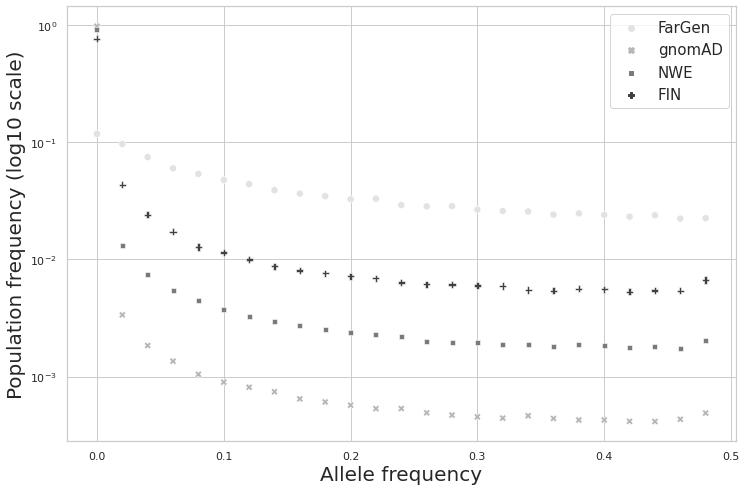

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.set_theme(style='whitegrid', font_scale=1.2)
sns.color_palette("pastel")

g = sns.scatterplot(
    data=fsfs_pd, x='af', y='ff', style='strata', hue='strata',
    ax=ax, s=50, palette='Greys'
)

_ = ax.set(yscale="log")

#_ = ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('1e%.1f'))
#_ = ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('1e%.1f'))
_ = ax.legend(prop={'size': 15})
_ = ax.set_xlabel('Allele frequency', fontsize=20)
_ = ax.set_ylabel('Population frequency (log10 scale)', fontsize=20)

In [36]:
fig = g.get_figure()
fig.savefig(BASE_DIR + '/data/figures/fsfs_pop.png', format='png', dpi=400)

## Count all effect types

Only for the first transcript in the list.

In [57]:
%%time

temp_ht = ht.filter(ht.info.AC_fae != 0)
effect1_list = temp_ht.effect1.collect()

[Stage 13:=======================================================>(78 + 1) / 79]

CPU times: user 433 ms, sys: 290 ms, total: 722 ms
Wall time: 11.9 s


In [58]:
len(effect1_list)

59352

In [59]:
effect1_small = effect1_list[:100000]

In [60]:
effect1_list_flat = [item for sublist in effect1_list for item in sublist]

In [61]:
%%time

effect_count = dict()
for effect in effect1_list_flat:
    count = effect_count.get(effect)
    if count is None:
        effect_count[effect] = 1
    else:
        effect_count[effect] += 1

CPU times: user 28.9 ms, sys: 146 µs, total: 29 ms
Wall time: 28.8 ms


In [62]:
sorted(effect_count.items(), key=lambda x: x[1], reverse=True)

[('intron_variant', 21755),
 ('synonymous_variant', 14228),
 ('missense_variant', 13230),
 ('splice_region_variant', 3365),
 ('upstream_gene_variant', 2042),
 ('3_prime_UTR_variant', 2017),
 ('downstream_gene_variant', 1850),
 ('5_prime_UTR_variant', 954),
 ('intergenic_region', 678),
 ('sequence_feature', 617),
 ('non_coding_transcript_exon_variant', 500),
 ('structural_interaction_variant', 493),
 ('frameshift_variant', 277),
 ('5_prime_UTR_premature_start_codon_gain_variant', 168),
 ('disruptive_inframe_deletion', 143),
 ('stop_gained', 129),
 ('conservative_inframe_deletion', 85),
 ('splice_acceptor_variant', 82),
 ('disruptive_inframe_insertion', 48),
 ('splice_donor_variant', 47),
 ('conservative_inframe_insertion', 40),
 ('start_lost', 38),
 ('stop_lost', 21),
 ('stop_retained_variant', 18),
 ('protein_protein_contact', 16),
 ('gene_fusion', 1)]

## Frequency correlation

In [325]:
p = hl.plot.scatter(ht.info.AF_fae, ht.info.AF_gnomad_all, xlabel='FarGen AF', ylabel='gnomAD AF', size=1)
p.plot_width = 800
p.plot_height = 400
show(p)

[Stage 48:=====================================================>  (75 + 4) / 79]